In [5]:
import os
import shutil
import pandas as pd

def copy_files_based_on_voltage_range(src_dir, dest_dir, column_name='LANTERN VOLTAGE (V)', voltage_range=0.8):
    # Ensure the destination directory exists
    os.makedirs(dest_dir, exist_ok=True)
    
    # Iterate over all files in the source directory
    for filename in os.listdir(src_dir):
        if filename.endswith('.xlsx'):
            file_path = os.path.join(src_dir, filename)
            
            try:
                # Read the Excel file
                df = pd.read_excel(file_path)
                
                # Check if the specified column exists in the DataFrame
                if column_name in df.columns:
                    # Calculate the range of the voltage column
                    voltage_diff = df[column_name].max() - df[column_name].min()
                    
                    # Check if the range is equal to or greater than the specified value
                    if voltage_diff >= voltage_range:
                        # Copy the file to the destination directory
                        shutil.copy2(file_path, os.path.join(dest_dir, filename))
                        print(f"Copied file: {filename}")
            except Exception as e:
                print(f"Error processing file {filename}: {e}")

# Example usage
src_directory = r'C:\Users\ahsani2\Documents\03- AI part\03 - Third Try\Dataset'
dest_directory = r'C:\Users\ahsani2\Documents\03- AI part\03 - Third Try\DatasetLanternsRange0.8'
copy_files_based_on_voltage_range(src_directory, dest_directory)


Copied file: ML10.xlsx
Copied file: ML14.xlsx
Copied file: ML26.xlsx
Copied file: ML29.xlsx
Copied file: ML3.xlsx
Copied file: ML31.xlsx
Copied file: ML34.xlsx
Copied file: ML36.xlsx
Copied file: ML4.xlsx
Copied file: ML40.xlsx
Copied file: ML44.xlsx
Copied file: ML48.xlsx
Copied file: ML5.xlsx
Copied file: ML54.xlsx
Copied file: ML6.xlsx
Copied file: ML8.xlsx


In [7]:
import os
import pandas as pd

def compute_soc(src_dir, column_name='LANTERN VOLTAGE (V)', soc_column_name='SoC(%)'):
    # Iterate over all files in the source directory
    for filename in os.listdir(src_dir):
        if filename.endswith('.xlsx'):
            file_path = os.path.join(src_dir, filename)
            
            try:
                # Read the Excel file
                df = pd.read_excel(file_path)
                
                # Check if the specified column exists in the DataFrame
                if column_name in df.columns:
                    # Get the minimum and maximum values from the voltage column
                    min_value = df[column_name].min()
                    max_value = df[column_name].max()
                    
                    # Compute the SoC(%) values and create the new column
                    df[soc_column_name] = 100 * (df[column_name] - min_value) / (max_value - min_value)
                    
                    # Save the modified DataFrame back to the Excel file
                    df.to_excel(file_path, index=False)
                    print(f"Processed file: {filename}")
            except Exception as e:
                print(f"Error processing file {filename}: {e}")

# Example usage
src_directory = r'C:\Users\ahsani2\Documents\03- AI part\03 - Third Try\DatasetLanternsRange0.8'
compute_soc(src_directory)


Processed file: ML10.xlsx
Processed file: ML14.xlsx
Processed file: ML26.xlsx
Processed file: ML29.xlsx
Processed file: ML3.xlsx
Processed file: ML31.xlsx
Processed file: ML34.xlsx
Processed file: ML36.xlsx
Processed file: ML4.xlsx
Processed file: ML40.xlsx
Processed file: ML44.xlsx
Processed file: ML48.xlsx
Processed file: ML5.xlsx
Processed file: ML54.xlsx
Processed file: ML6.xlsx
Processed file: ML8.xlsx


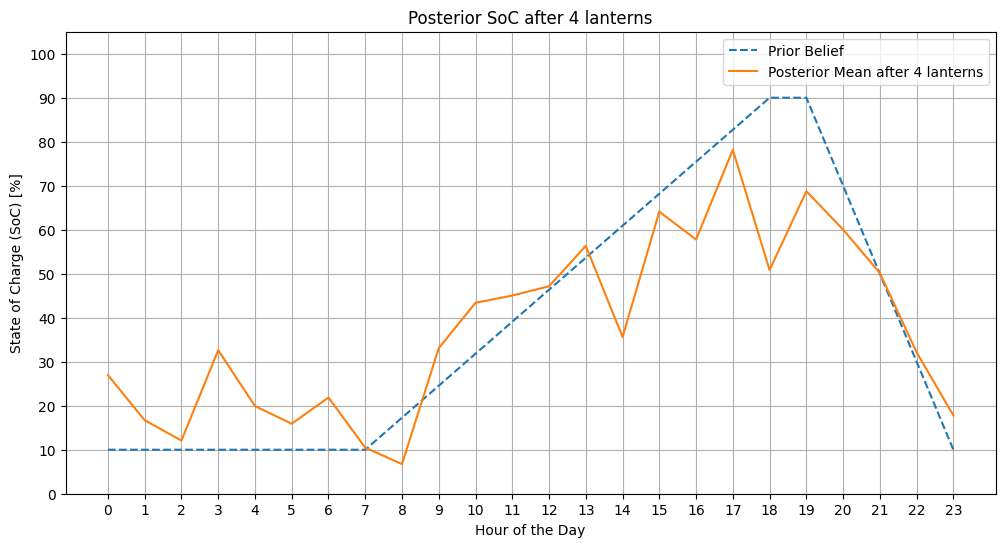

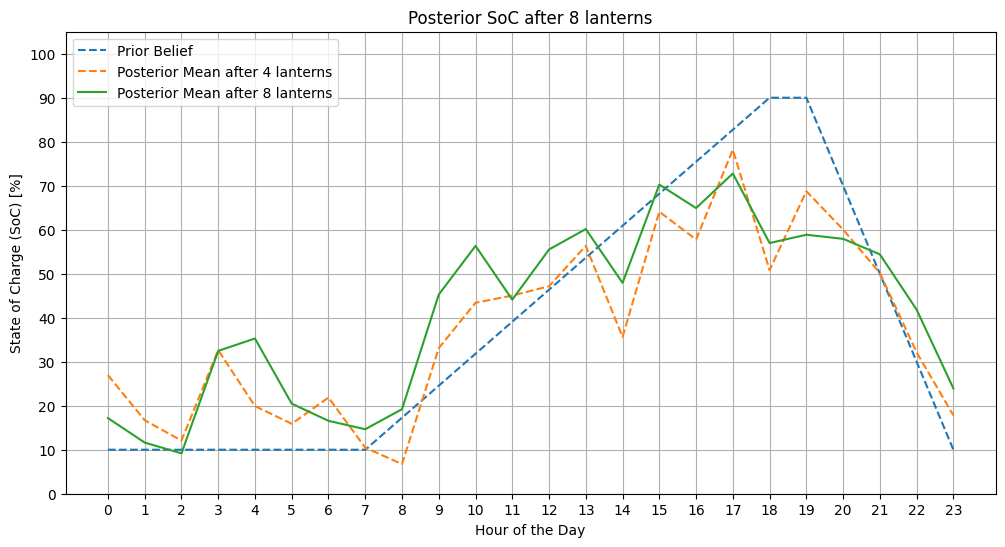

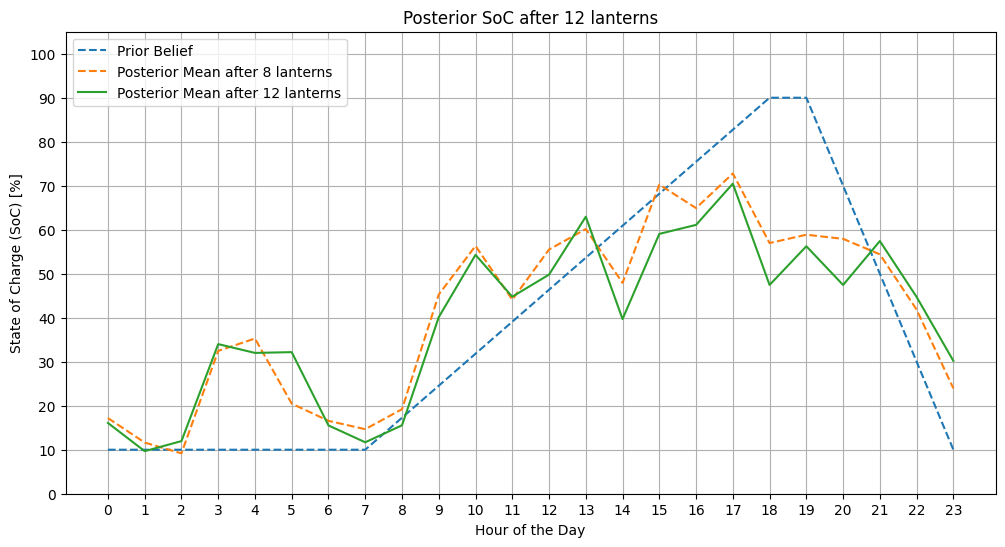

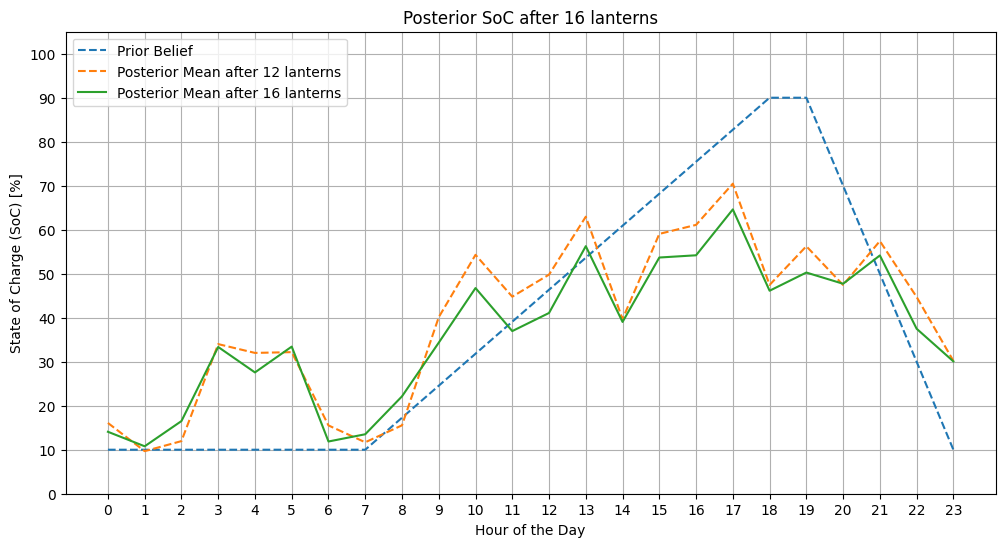

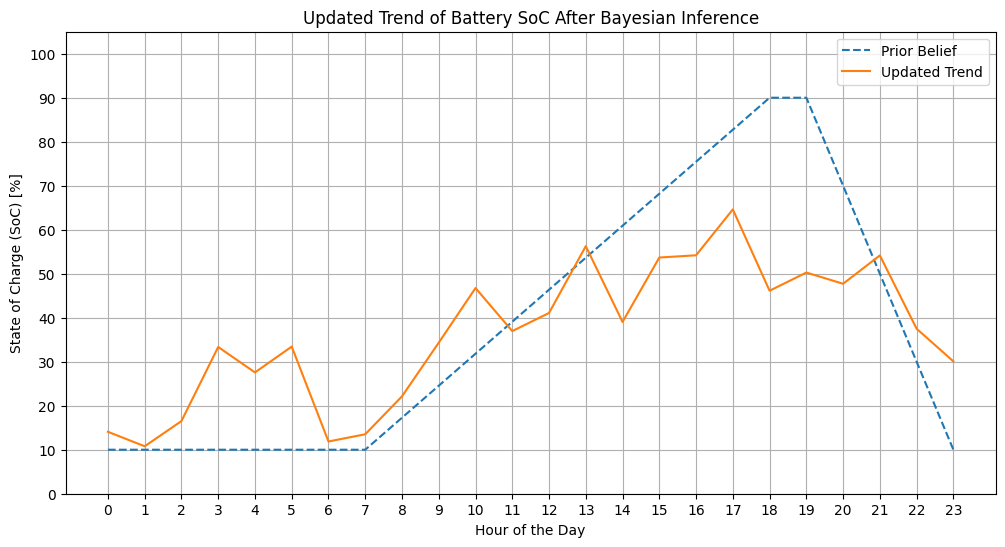

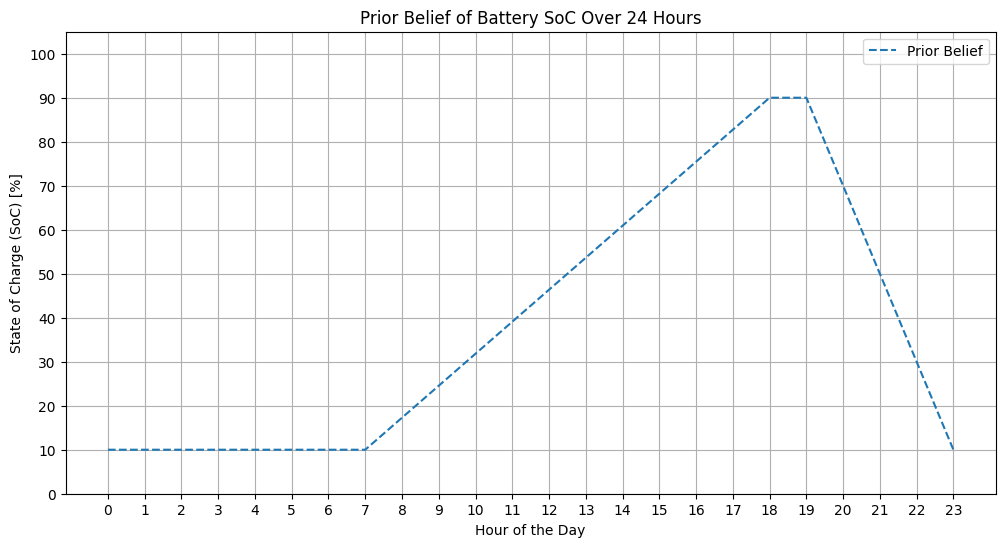

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

# Define the hours of the day
hours = np.arange(0, 24, 1)

# Function to read data from Excel files in a directory
def read_data_from_directory(directory):
    files = glob.glob(os.path.join(directory, '*.xlsx'))
    soc_data = []
    for file in files:
        df = pd.read_excel(file)
        df['hour'] = pd.to_datetime(df['datetime']).dt.hour
        hourly_soc = df.groupby('hour')['SoC(%)'].mean()
        soc_data.append(hourly_soc.reindex(np.arange(0, 24), fill_value=0).values)
    return np.array(soc_data), len(files)

# Directory containing the Excel files
directory = r'C:\Users\ahsani2\Documents\03- AI part\03 - Third Try\DatasetLanternsRange0.8'  # Replace with the actual path to the directory

# Read data
soc_data, num_users = read_data_from_directory(directory)

# Initial assumption of SoC (prior belief) in percentage
soc_initial = np.zeros(24)
soc_initial[19:24] = np.linspace(90, 10, 5)  # 5pm to 12am decrease
soc_initial[0:7] = 10  # 12am to 6am low
soc_initial[7:19] = np.linspace(10, 90, 12)  # 6am to 5pm increase

# Bayesian inference
prior_belief = soc_initial
prior_variance = 100  # Initial variance

posterior_mean = np.zeros((num_users, 24))
posterior_variance = np.zeros((num_users, 24))

# Perform Bayesian update iteratively
for i in range(num_users):
    user_data = soc_data[i, :]  # Data from lantern i

    # Bayesian update
    posterior_mean[i, :] = (prior_belief / prior_variance + user_data / 100) / (1 / prior_variance + 1 / 100)
    posterior_variance[i, :] = 1 / (1 / prior_variance + 1 / 100)

    # Visualize intermediate result
    if (i + 1) % 4 == 0 or i == num_users - 1:
        plt.figure(figsize=(12, 6))
        plt.plot(hours, soc_initial, label='Prior Belief', linestyle='--')
        if i >= 4:
            plt.plot(hours, posterior_mean[i-4, :], label=f'Posterior Mean after {i-3} lanterns', linestyle='--')
        plt.plot(hours, posterior_mean[i, :], label=f'Posterior Mean after {i + 1} lanterns')
        plt.xticks(hours)  # Show all hours on the x-axis
        plt.yticks(np.arange(0, 110, 10))  # Show y-axis from 0% to 100% in increments of 10%
        plt.ylim(0, 105)  # Extend y-axis limits slightly beyond 100%
        plt.xlabel('Hour of the Day')
        plt.ylabel('State of Charge (SoC) [%]')
        plt.title(f'Posterior SoC after {i + 1} lanterns')
        plt.legend()
        plt.grid(True)
        plt.show()

    # Update prior for next iteration
    prior_belief = posterior_mean[i, :]
    prior_variance = posterior_variance[i, :]

# Final posterior mean
final_posterior_mean = posterior_mean[-1, :]
final_posterior_variance = posterior_variance[-1, :]

plt.figure(figsize=(12, 6))
plt.plot(hours, soc_initial, label='Prior Belief', linestyle='--')
plt.plot(hours, final_posterior_mean, label='Updated Trend')
plt.xticks(hours)  # Show all hours on the x-axis
plt.yticks(np.arange(0, 110, 10))  # Show y-axis from 0% to 100% in increments of 10%
plt.ylim(0, 105)  # Extend y-axis limits slightly beyond 100%
plt.xlabel('Hour of the Day')
plt.ylabel('State of Charge (SoC) [%]')
plt.title('Updated Trend of Battery SoC After Bayesian Inference')
plt.legend()
plt.grid(True)
plt.show()

# Separate plot showing only prior belief
plt.figure(figsize=(12, 6))
plt.plot(hours, soc_initial, label='Prior Belief', linestyle='--')
plt.xticks(hours)  # Show all hours on the x-axis
plt.yticks(np.arange(0, 110, 10))  # Show y-axis from 0% to 100% in increments of 10%
plt.ylim(0, 105)  # Extend y-axis limits slightly beyond 100%
plt.xlabel('Hour of the Day')
plt.ylabel('State of Charge (SoC) [%]')
plt.title('Prior Belief of Battery SoC Over 24 Hours')
plt.legend()
plt.grid(True)
plt.show()


In [6]:
# Create a DataFrame to store the probabilities
probabilities_df = pd.DataFrame(index=hours, columns=['Hour of the Day', 'Mean SoC (%)', '95% Confidence Interval'])

# Add Hour of the Day column
probabilities_df['Hour of the Day'] = hours

# Calculate 95% confidence interval
z_score = 1.96  # for 95% confidence interval: The 95% confidence interval is a range of values that's likely to contain the true mean of a population with 95% certainty.
confidence_interval = z_score * np.sqrt(final_posterior_variance)

# Calculate lower and upper bounds of the confidence interval
lower_bound = np.maximum(0, final_posterior_mean - confidence_interval)
upper_bound = np.minimum(100, final_posterior_mean + confidence_interval)

# Round mean and confidence interval to whole numbers
mean_rounded = np.round(final_posterior_mean)
lower_bound_rounded = np.round(lower_bound)
upper_bound_rounded = np.round(upper_bound)

# Format confidence interval as [lower%, upper%]
confidence_interval_formatted = ['[{}%, {}%]'.format(lower, upper) for lower, upper in zip(lower_bound_rounded, upper_bound_rounded)]

# Fill DataFrame with rounded mean and confidence interval values
probabilities_df['Mean SoC (%)'] = mean_rounded
probabilities_df['95% Confidence Interval'] = confidence_interval_formatted

# Display the DataFrame
print(probabilities_df)


    Hour of the Day  Mean SoC (%) 95% Confidence Interval
0                 0          14.0           [9.0%, 19.0%]
1                 1          11.0           [6.0%, 16.0%]
2                 2          17.0          [12.0%, 21.0%]
3                 3          33.0          [29.0%, 38.0%]
4                 4          28.0          [23.0%, 32.0%]
5                 5          33.0          [29.0%, 38.0%]
6                 6          12.0           [7.0%, 17.0%]
7                 7          14.0           [9.0%, 19.0%]
8                 8          23.0          [18.0%, 27.0%]
9                 9          35.0          [30.0%, 40.0%]
10               10          47.0          [43.0%, 52.0%]
11               11          38.0          [33.0%, 42.0%]
12               12          42.0          [37.0%, 47.0%]
13               13          57.0          [52.0%, 62.0%]
14               14          40.0          [35.0%, 45.0%]
15               15          54.0          [50.0%, 59.0%]
16            